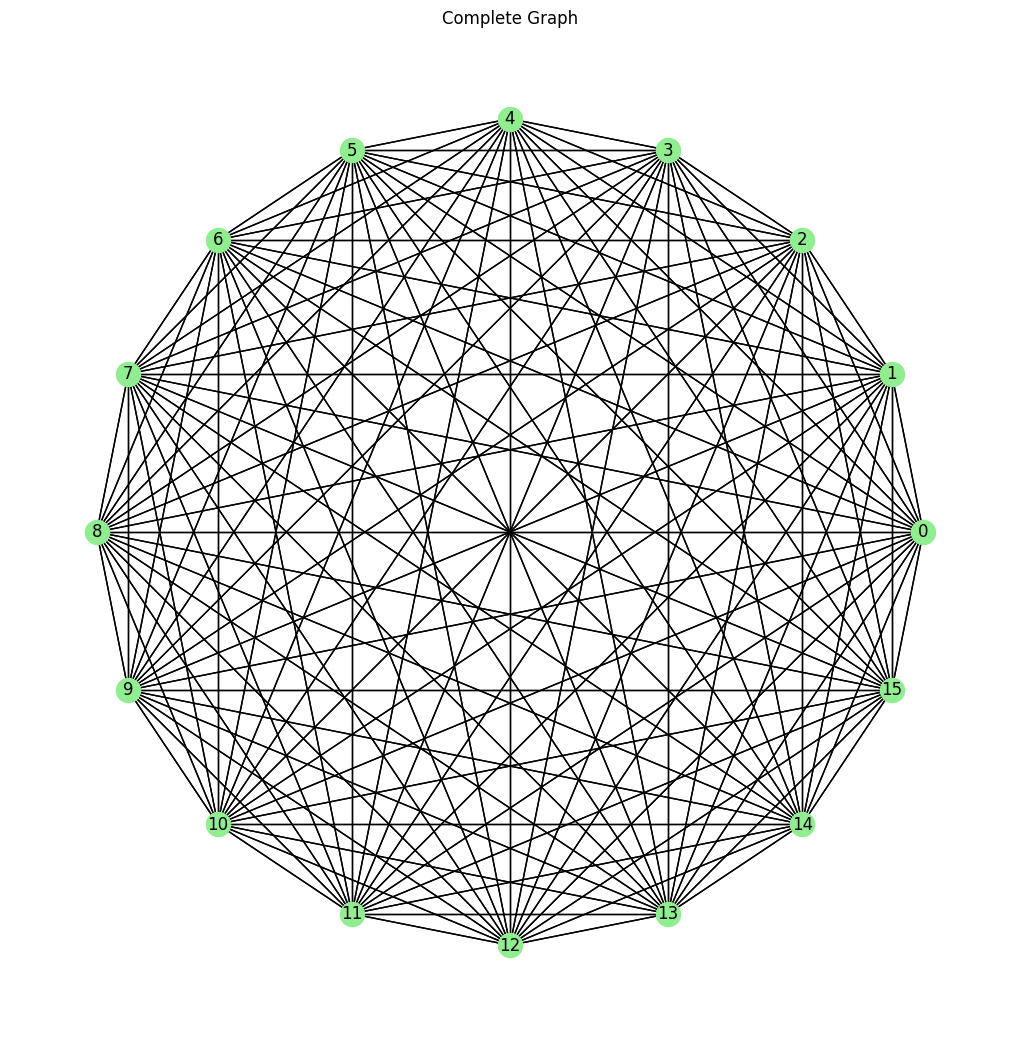

In [1]:
from topology import generate_complete_graph, draw_graph

G = generate_complete_graph(16)
draw_graph(G)


# Slicing Generation

In [2]:
from generate_slices import generate_random_slices, vnf_profiles
import pandas as pd

# Generate the slices
slices = generate_random_slices(G, vnf_profiles, 6)

# Convert to readable table
slices_data = []
for i, (vnfs, vls) in enumerate(slices):
    slices_data.append({
        "Slice": i + 1,
        "VNF IDs": [v["id"] for v in vnfs],
        "VNF CPUs": [v["cpu"] for v in vnfs],
        "VL Pairs": [(vl["from"], vl["to"]) for vl in vls],
        "VL Bandwidths": [vl["bandwidth"] for vl in vls],
        "VL Latencies": [vl["latency"] for vl in vls]
    })

df_slices = pd.DataFrame(slices_data)
df_slices


,Slice,VNF IDs,VNF CPUs,VL Pairs,VL Bandwidths,VL Latencies
0,1,"[vnf0_0, vnf0_1, vnf0_2]","[3, 3, 3]","[(vnf0_0, vnf0_1), (vnf0_1, vnf0_2)]","[80, 80]","[25, 25]"
1,2,"[vnf1_0, vnf1_1, vnf1_2]","[2, 2, 2]","[(vnf1_0, vnf1_1), (vnf1_1, vnf1_2)]","[100, 100]","[25, 25]"
2,3,"[vnf2_0, vnf2_1, vnf2_2]","[1, 1, 1]","[(vnf2_0, vnf2_1), (vnf2_1, vnf2_2)]","[120, 120]","[25, 25]"
3,4,"[vnf3_0, vnf3_1, vnf3_2]","[1, 1, 1]","[(vnf3_0, vnf3_1), (vnf3_1, vnf3_2)]","[120, 120]","[25, 25]"
4,5,"[vnf4_0, vnf4_1, vnf4_2]","[2, 2, 2]","[(vnf4_0, vnf4_1), (vnf4_1, vnf4_2)]","[100, 100]","[25, 25]"
5,6,"[vnf5_0, vnf5_1, vnf5_2]","[1, 1, 1]","[(vnf5_0, vnf5_1), (vnf5_1, vnf5_2)]","[120, 120]","[25, 25]"


In [3]:
from run_abo_full_batch import run_abo_full_batch

node_capacity = {node: 10 for node in G.nodes}
link_latency = {(u, v): G[u][v]['latency'] for u, v in G.edges}
link_capacity = {(u, v): G[u][v]['capacity'] for u, v in G.edges}

df_results, abo_results = run_abo_full_batch(
    G,
    slices,
    node_capacity,            
    link_latency,             
    link_capacity             
)

print (df_results)
print (abo_results)

   slice  accepted  g_cost
0      1      True     160
1      2      True     200
2      3      True     240
3      4      True     240
4      5      True     200
5      6      True     240
[<run_abo_full_batch.ABOState object at 0x7f83d0d83ef0>, <run_abo_full_batch.ABOState object at 0x7f83d0da7620>, <run_abo_full_batch.ABOState object at 0x7f83d0dffad0>, <run_abo_full_batch.ABOState object at 0x7f83d0de3980>, <run_abo_full_batch.ABOState object at 0x7f83d0de2ed0>, <run_abo_full_batch.ABOState object at 0x7f83d0da6000>]


In [4]:
# Recreate the DataFrame from stored slices (reconstruct summary if needed)
abo_summary = []
for i, result in enumerate(abo_results):
    abo_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": result.g_cost if result else None
    })

# Compute metrics
accepted_costs = [entry["g_cost"] for entry in abo_summary if entry["accepted"]]
average_g_cost = sum(accepted_costs) / len(accepted_costs)
min_g_cost = min(accepted_costs)
max_g_cost = max(accepted_costs)

# Display metrics
{
    "Average g_cost (Mbps)": average_g_cost,
    "Min g_cost (Mbps)": min_g_cost,
    "Max g_cost (Mbps)": max_g_cost,
    "Total slices": len(abo_summary),
    "Accepted slices": len(accepted_costs),
    "Acceptance rate (%)": (len(accepted_costs) / len(abo_summary)) * 100
}


{'Average g_cost (Mbps)': 213.33333333333334,
 'Min g_cost (Mbps)': 160,
 'Max g_cost (Mbps)': 240,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [5]:
import pandas as pd
vnf_placement_data = []

for slice_index, result in enumerate(abo_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement.head()


,Slice,VNF,Node
0,1,vnf0_0,15
1,1,vnf0_1,0
2,1,vnf0_2,0
3,2,vnf1_0,7
4,2,vnf1_1,7


In [6]:
vl_routing_data = []

for slice_index, result in enumerate(abo_results):
    if result is not None:
        for (src, dst), path in result.routed_vls.items():
            vl_routing_data.append({
                "Slice": slice_index + 1,
                "VL": f"{src} → {dst}",
                "Path": " → ".join(str(n) for n in path)
            })

df_routing = pd.DataFrame(vl_routing_data)
df_routing.head()


,Slice,VL,Path
0,1,vnf0_0 → vnf0_1,15 → 0
1,1,vnf0_1 → vnf0_2,0
2,2,vnf1_0 → vnf1_1,7
3,2,vnf1_1 → vnf1_2,7
4,3,vnf2_0 → vnf2_1,14


# First-fit Orchestration 

In [7]:
from first_fit import run_first_fit

ff_df, ff_results, final_node_capacity = run_first_fit(G, slices, node_capacity)


In [8]:
ff_summary = []
for i, result in enumerate(ff_results):  
    ff_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": 0 if result else None 
    })

accepted_ff = [entry for entry in ff_summary if entry["accepted"]]

# Display metrics para First Fit
{
    "Average g_cost (Mbps)": None,
    "Min g_cost (Mbps)": None,
    "Max g_cost (Mbps)": None,
    "Total slices": len(ff_summary),
    "Accepted slices": len(accepted_ff),
    "Acceptance rate (%)": (len(accepted_ff) / len(ff_summary)) * 100
}


{'Average g_cost (Mbps)': None,
 'Min g_cost (Mbps)': None,
 'Max g_cost (Mbps)': None,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [9]:
for i, result in enumerate(ff_results):
    print(f"Slice {i+1}: {'Accepted' if result else 'Rejected'}")


Slice 1: Accepted
Slice 2: Accepted
Slice 3: Accepted
Slice 4: Accepted
Slice 5: Accepted
Slice 6: Accepted


In [10]:
final_node_capacity = node_capacity.copy()

for result in ff_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 0: 0
Node 1: 0
Node 2: 0
Node 3: 10
Node 4: 10
Node 5: 10
Node 6: 10
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 10
Node 12: 10
Node 13: 10
Node 14: 10
Node 15: 10


In [11]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(ff_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,0
1,1,vnf0_1,0
2,1,vnf0_2,0
3,2,vnf1_0,1
4,2,vnf1_1,1
5,2,vnf1_2,1
6,3,vnf2_0,0
7,3,vnf2_1,1
8,3,vnf2_2,1
9,4,vnf3_0,1


# A* 

In [12]:
from a_star import run_astar_full_batch

astar_df, astar_results = run_astar_full_batch(
        G, 
        slices, 
        node_capacity, 
        link_latency, 
        link_capacity)

print (astar_df)
print (astar_results)

   slice  accepted  g_cost
0      1      True     160
1      2      True     200
2      3      True     240
3      4      True     240
4      5      True     200
5      6      True     240
[<a_star.AStarState object at 0x7f83d0dfd6a0>, <a_star.AStarState object at 0x7f83d0de3500>, <a_star.AStarState object at 0x7f83d0da6120>, <a_star.AStarState object at 0x7f83d0dff950>, <a_star.AStarState object at 0x7f83d0de0bc0>, <a_star.AStarState object at 0x7f83d0da6390>]


In [13]:
astar_summary = []
for i, result in enumerate(astar_results):  
    astar_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": 0 if result else None 
    })

accepted_astar = [entry for entry in astar_summary if entry["accepted"]]

# Display metrics para First Fit
{
    "Average g_cost (Mbps)": None,
    "Min g_cost (Mbps)": None,
    "Max g_cost (Mbps)": None,
    "Total slices": len(astar_summary),
    "Accepted slices": len(accepted_astar),
    "Acceptance rate (%)": (len(accepted_astar) / len(astar_summary)) * 100
}


{'Average g_cost (Mbps)': None,
 'Min g_cost (Mbps)': None,
 'Max g_cost (Mbps)': None,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [14]:
final_node_capacity = node_capacity.copy()

for result in astar_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 0: 10
Node 1: 3
Node 2: 6
Node 3: 10
Node 4: 6
Node 5: 10
Node 6: 10
Node 7: 10
Node 8: 10
Node 9: 7
Node 10: 1
Node 11: 7
Node 12: 10
Node 13: 10
Node 14: 10
Node 15: 10


In [15]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(astar_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,1
1,1,vnf0_1,11
2,1,vnf0_2,9
3,2,vnf1_0,4
4,2,vnf1_1,2
5,2,vnf1_2,1
6,3,vnf2_0,10
7,3,vnf2_1,10
8,3,vnf2_2,10
9,4,vnf3_0,10


# FABO

In [16]:
from run_fabo_full_batch import run_fabo_full_batch
from tqdm import tqdm

fabo_df, fabo_results = run_fabo_full_batch(G, slices, node_capacity, link_latency, link_capacity)

print (fabo_df)
print (fabo_results)


Running FABO: 100%|██████████| 6/6 [00:00<00:00, 82.75slice/s]

Trying to place vnf0_0 on node 0 (CPU available: 10, CPU needed: 3)
Trying to place vnf0_0 on node 1 (CPU available: 10, CPU needed: 3)
Trying to place vnf0_0 on node 2 (CPU available: 10, CPU needed: 3)
Trying to place vnf0_0 on node 3 (CPU available: 10, CPU needed: 3)
Trying to place vnf0_0 on node 4 (CPU available: 10, CPU needed: 3)
Trying to place vnf0_1 on node 1 (CPU available: 10, CPU needed: 3)
Insufficient bandwidth on link (0, 1): 53 < 80
Trying to place vnf0_1 on node 2 (CPU available: 10, CPU needed: 3)
Insufficient bandwidth on link (0, 7): 53 < 80
Trying to place vnf0_1 on node 3 (CPU available: 10, CPU needed: 3)
Insufficient bandwidth on link (0, 7): 53 < 80
Trying to place vnf0_1 on node 4 (CPU available: 10, CPU needed: 3)
Trying to place vnf0_1 on node 5 (CPU available: 10, CPU needed: 3)
Insufficient bandwidth on link (4, 5): 64 < 80
Trying to place vnf0_1 on node 0 (CPU available: 10, CPU needed: 3)
Insufficient bandwidth on link (2, 0): 55 < 80
Trying to place v

In [17]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(fabo_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,3
1,1,vnf0_1,4
2,1,vnf0_2,6
3,2,vnf1_0,2
4,2,vnf1_1,1
5,2,vnf1_2,4
6,3,vnf2_0,2
7,3,vnf2_1,1
8,3,vnf2_2,0
9,4,vnf3_0,2


In [18]:
final_node_capacity = node_capacity.copy()

for result in fabo_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 0: 7
Node 1: 3
Node 2: 3
Node 3: 7
Node 4: 3
Node 5: 10
Node 6: 7
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 10
Node 12: 10
Node 13: 10
Node 14: 10
Node 15: 10


# Comparasion

In [19]:
from compute_energy import compute_energy_per_slice


energy_abo_per_slice, cpu_abo_all = compute_energy_per_slice(abo_results, slices, node_capacity)
energy_ff_per_slice, cpu_ff_all = compute_energy_per_slice(ff_results, slices, node_capacity)
energy_astar_per_slice, cpu_astar_all = compute_energy_per_slice(astar_results, slices, node_capacity)
energy_fabo_per_slice, cpu_fabo_all = compute_energy_per_slice(fabo_results, slices, node_capacity)



In [20]:
comparison = df_results.copy()
comparison["energy_abo"] = energy_abo_per_slice
comparison["energy_ff"] = energy_ff_per_slice
comparison["energy_astar"] = energy_astar_per_slice
comparison["energy_fabo"] = energy_fabo_per_slice


totals_row = {
    "slice": "Total",
    "energy_abo": comparison["energy_abo"].sum(),
    "energy_ff": comparison["energy_ff"].sum(),
    "energy_astar": comparison["energy_astar"].sum(),
    "energy_fabo": comparison["energy_fabo"].sum()
}

comparison_with_total = pd.concat([comparison, pd.DataFrame([totals_row])], ignore_index=True)
comparison_with_total


comparison_with_total


,slice,accepted,g_cost,energy_abo,energy_ff,energy_astar,energy_fabo
0,1,True,160.0,28,23,33,33
1,2,True,200.0,17,17,27,27
2,3,True,240.0,11,16,11,21
3,4,True,240.0,11,16,11,21
4,5,True,200.0,17,17,27,27
5,6,True,240.0,11,11,11,21
6,Total,NaN,NaN,95,100,120,150


<Axes: title={'center': 'CPU Usage per Node by Algorithm'}, xlabel='Node'>

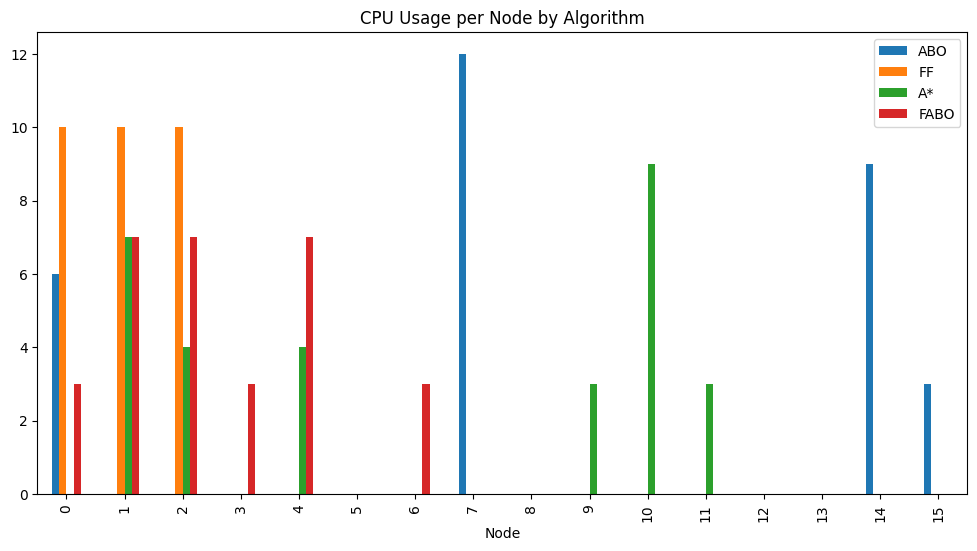

In [21]:
from compute_energy import compute_energy_per_slice
import pandas as pd

def get_cpu_distribution(results, slices, node_capacity):
    cpu_usage_total = {n: 0 for n in node_capacity}
    _ , cpu_usage_slice = compute_energy_per_slice(results, slices, node_capacity)
    for slice_cpu in cpu_usage_slice:
        for n, cpu in slice_cpu.items():
            cpu_usage_total[n] += cpu
    return cpu_usage_total


cpu_abo_all = get_cpu_distribution(abo_results, slices, node_capacity)
cpu_ff_all = get_cpu_distribution(ff_results, slices, node_capacity)
cpu_astar_all = get_cpu_distribution(astar_results, slices, node_capacity)
cpu_fabo_all = get_cpu_distribution(fabo_results, slices, node_capacity)

# Montagem do DataFrame
df_cpu = pd.DataFrame({
    "Node": list(cpu_abo_all.keys()),
    "ABO": list(cpu_abo_all.values()),
    "FF": list(cpu_ff_all.values()),
    "A*": list(cpu_astar_all.values()),
    "FABO": list(cpu_fabo_all.values()),
}).set_index("Node")

df_cpu

df_cpu.plot(kind='bar', figsize=(12, 6), title="CPU Usage per Node by Algorithm")



In [28]:
from compute_energy import compute_total_latency
from compute_energy import compute_total_bandwidth

latency_abo = compute_total_latency(abo_results, link_latency)
#latency_ff = compute_total_latency(ff_results, link_latency)
latency_astar = compute_total_latency(astar_results, link_latency)
latency_fabo = compute_total_latency(fabo_results, link_latency)

bandwidth_abo = compute_total_bandwidth(abo_results, slices)
#bandwidth_ff = compute_total_bandwidth(ff_results, slices)
bandwidth_astar = compute_total_bandwidth(astar_results, slices)
bandwidth_fabo = compute_total_bandwidth(fabo_results, slices)

comparison["latency_abo"] = latency_abo
#comparison["latency_ff"] = latency_ff
comparison["latency_astar"] = latency_astar
comparison["latency_fabo"] = latency_fabo

comparison["bandwidth_abo"] = bandwidth_abo
#comparison["bandwidth_ff"] = bandwidth_ff
comparison["bandwidth_astar"] = bandwidth_astar
comparison["bandwidth_fabo"] = bandwidth_fabo


totals_row.update({
    "latency_abo": comparison["latency_abo"].sum(),
    #"latency_ff": comparison["latency_ff"].sum(),
    "latency_astar": comparison["latency_astar"].sum(),
    "latency_fabo": comparison["latency_fabo"].sum(),
    "bandwidth_abo": comparison["bandwidth_abo"].sum(),
    #"bandwidth_ff": comparison["bandwidth_ff"].sum(),
    "bandwidth_astar": comparison["bandwidth_astar"].sum(),
    "bandwidth_fabo": comparison["bandwidth_fabo"].sum(),
})


comparison_with_total = pd.concat([comparison, pd.DataFrame([totals_row])], ignore_index=True)


comparison_with_total


,slice,accepted,g_cost,energy_abo,energy_ff,energy_astar,energy_fabo,latency_abo,bandwidth_abo,latency_astar,latency_fabo,bandwidth_astar,bandwidth_fabo
0,1,True,160.0,28,23,33,33,3,160,6,4,160,160
1,2,True,200.0,17,17,27,27,0,200,7,8,200,200
2,3,True,240.0,11,16,11,21,0,240,0,7,240,240
3,4,True,240.0,11,16,11,21,0,240,0,7,240,240
4,5,True,200.0,17,17,27,27,0,200,7,8,200,200
5,6,True,240.0,11,11,11,21,0,240,0,7,240,240
6,Total,NaN,NaN,95,100,120,150,3,1280,20,41,1280,1280


In [30]:
slice_stats = []

for i, (vnf_chain, vl_chain) in enumerate(slices):
    num_vnfs = len(vnf_chain)
    num_vls = len(vl_chain)
    total_cpu = sum(v["cpu"] for v in vnf_chain)
    avg_cpu = total_cpu / num_vnfs if num_vnfs else 0
    total_bw = sum(vl["bandwidth"] for vl in vl_chain)
    avg_bw = total_bw / num_vls if num_vls else 0
    max_latency = max((vl["latency"] for vl in vl_chain), default=0)

    slice_stats.append({
        "Slice": i + 1,
        "Num_VNFs": num_vnfs,
        "Num_VLs": num_vls,
        "Total_CPU": total_cpu,
        "Avg_CPU": round(avg_cpu, 2),
        "Total_BW": total_bw,
        "Avg_BW": round(avg_bw, 2),
        "Max_Latency_Constraint": max_latency,
    })

import pandas as pd
df_slice_stats = pd.DataFrame(slice_stats)
df_slice_stats


,Slice,Num_VNFs,Num_VLs,Total_CPU,Avg_CPU,Total_BW,Avg_BW,Max_Latency_Constraint
0,1,3,2,9,3.0,160,80.0,25
1,2,3,2,6,2.0,200,100.0,25
2,3,3,2,3,1.0,240,120.0,25
3,4,3,2,3,1.0,240,120.0,25
4,5,3,2,6,2.0,200,100.0,25
5,6,3,2,3,1.0,240,120.0,25
